# This notebook is for finding latest active addresses (and their selected token pairs) in pancakeswap. 

In [36]:
import pandas as pd
import math
import requests
import json
import numpy as np
import webbrowser
import time

from web3 import Web3
from web3.middleware import geth_poa_middleware

from hexbytes import HexBytes as hb
pd.set_option('display.max_columns', 500)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

%load_ext autoreload
%autoreload 2
from functions import * # most functions are kept there for convenience
bsc_scan_api_key = "ID63Y14WNZY1NTAP8DEHN28KTC4NZAVHM4"

binance_provider = 'https://bsc-dataseed.binance.org' 
w3 = Web3(Web3.HTTPProvider(binance_provider))



pair_address="0xb5d7cc509f9de98e35f054392666122fdd4def47" # token_names = {"token0":"DARK","token1":"BUSD"}
#  information about the pair
abi = get_bsc_contract_abi(bsc_scan_api_key, pair_address) # gets an abi for the pair contract - it is universal for pancakeswap at least
token_abi = get_bsc_contract_abi(bsc_scan_api_key, "0x55d398326f99059fF775485246999027B3197955") # get a generic token abi to be able to read token contract symbol
pair_info = get_pair_info(pair_address,abi,bsc_scan_api_key,w3,token_abi) # get pair info
# need this only to parse Swap data using abi event signatures 
signatures = get_signatures_from_abi(abi) # extracts signatures of events in abi - it is universal for pancakeswap at least

pair_info["signatures"] = signatures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get the latest transactions in pancake_swap from bsc_scan_api
##### (seems much faster than using web3)

In [6]:
# write hours that you want to scrape
scrape_last_hours = 1
# BSC blocks are once every 3 seconds
blocks_every_n_seconds = 3

blocks_ago = scrape_last_hours*60*60//3
results=get_bsc_historical_pancake_swaps(fromBlock=w3.eth.blockNumber-blocks_ago, toBlock=w3.eth.blockNumber, bsc_scan_api_key=bsc_scan_api_key)

getting BSC Historical Logs from block 23115348 to block 23118948...
Found 1000 txs from 23115348 block to 23115419 block.
Found 1000 txs from 23115419 block to 23115488 block.
Found 1000 txs from 23115488 block to 23115552 block.
Found 1000 txs from 23115552 block to 23115624 block.
Found 1000 txs from 23115624 block to 23115699 block.
Found 1000 txs from 23115699 block to 23115776 block.
Found 1000 txs from 23115776 block to 23115857 block.
Found 1000 txs from 23115857 block to 23115933 block.
Found 1000 txs from 23115933 block to 23116023 block.
Found 1000 txs from 23116023 block to 23116104 block.
Found 1000 txs from 23116104 block to 23116173 block.
Found 1000 txs from 23116173 block to 23116243 block.
Found 1000 txs from 23116243 block to 23116317 block.
Found 1000 txs from 23116317 block to 23116385 block.
Found 1000 txs from 23116385 block to 23116464 block.
Found 1000 txs from 23116464 block to 23116544 block.
Found 1000 txs from 23116544 block to 23116622 block.
Found 1000 tx

## Crude analysis and filtering of addresses 

In [7]:
# FILTER OUT AND ANALYSE ACTIVE ADDRESSES

df = pd.DataFrame(results) # turn the list of dictionary to pandas dataframe
df = parse_results_dataframe(df,pair_info) # parse the tx info 

# drop Swap receivers that are known token addresses or token pairs. 

# swapping_contracts=[
#     "0x10ed43c718714eb63d5aa57b78b54704e256024e", # PancakeSwap: Router v2 contract address 
#     "0x7efaef62fddcca950418312c6c91aef321375a00", # Pancake LPs (Cake-LP)
#     "0x16b9a82891338f9ba80e2d6970fdda79d1eb0dae", # USDT/WBNB
#     "0x58f876857a02d6762e0101bb5c46a8c1ed44dc16", # WBNB/USDT
#     "0x804678fa97d91b974ec2af3c843270886528a9e6", # Cake/BUSD
#     "0x0ed7e52944161450477ee417de9cd3a859b14fd0", # Cake/WBNB
#     "0x90c7c04457f3649a50bcbfa5a6b0711dd093b5ce", # WBNB/DW2
#     "0xbb6e2f4f94c2f5907379f0675a92a0c20c1bed31", # WBNB/ToolDOGE
#     "0x804678fa97d91b974ec2af3c843270886528a9e6", # Cake/BUSD
# ] # it is endless
swapping_contracts = list(set(df.contract_address)) + [
    "0x10ed43c718714eb63d5aa57b78b54704e256024e",# PancakeSwap: Router v2 contract address 
    "0x000000000000000000000000000000000000dead",# null address for token burning
] 
df = df[~df['To'].isin(swapping_contracts)] # drop swaps that contain these addresses as to. Only can contain (and will contain) as From for simple swaps

hour_window = (df.timeStamp.max() - df.timeStamp.min()) / (60*60)
print(f"Table contains {len(df)} txs from {df.DateTime.min()} to {df.DateTime.max()}, which is {round(hour_window,2)} hour window")


# Crude analysis of every address: txs_from_address, percent_txs_from_address
all_swaps=df[df.event == "Swap"]

# Select a treshold of swaps that need to be made by any single address to stay in dataframe
all_swaps = keep_active_adresses(all_swaps = all_swaps, at_least_swaps = 5) # rapidly filters out the majority of adresses that had very few swaps

# get percent fraction of txs made by this address compared to all txs
all_swappers = set(all_swaps.dropna(subset=["To"]).To.to_list())
all_swappers.discard(pair_address)
all_swappers.discard("0x0000000000000000000000000000000000000000")
iteration=0
total_token1_volume_by_all_addresses = (all_swaps["amount1In"].sum() + all_swaps["amount1Out"].sum())
total_token0_volume_by_all_addresses = (all_swaps["amount0In"].sum() + all_swaps["amount0Out"].sum())
analyzed_swaps = pd.DataFrame()
for address in list(all_swappers):
    # print(address)
    address_swaps= all_swaps[(all_swaps.To == address)].copy()
    if len(address_swaps)<4:
        # print("skipping")
        continue
    iteration+=1
    print(f"Analysing address {iteration} out of {len(list(all_swappers))}", end = "\r")
    address_swaps["txs_from_address"] = len(address_swaps)
    address_swaps["percent_txs_from_address"] = round((len(address_swaps)/len(all_swaps)*100), 4)  # len(txs) / len(swaps) * 100%

    # find sandwitch bots: quick way: check how many txs were in the same block
    # address_swaps["txs_in_same_block"] = len(set(address_swaps.transactionHash)) - len(set(address_swaps.drop_duplicates("transactionHash").blockNumber))
    most_common_pair_address = max(set(address_swaps.contract_address.to_list()), key = address_swaps.contract_address.to_list().count) 
    address_swaps["most_common_pair_address"] = most_common_pair_address
    address_swaps["focused_on_single_pair"] = (len(set(address_swaps.contract_address.to_list())) == 1)

    # measure volume
    total_amount1Out_by_address = sum(address_swaps["amount1Out"])
    total_amount1In_by_address = sum(address_swaps["amount1In"])
    address_swaps["total_amount1Out_by_address"] = total_amount1Out_by_address # selects where to is the address and prescribes a value which is sum of this same table 
    address_swaps["total_amount1In_by_address"] = total_amount1In_by_address
    address_swaps["total_token1_volume_by_address"] = total_amount1Out_by_address + total_amount1In_by_address

    total_amount0Out_by_address = sum(address_swaps["amount0Out"])
    total_amount0In_by_address = sum(address_swaps["amount0In"])
    address_swaps["total_amount0Out_by_address"] = total_amount0Out_by_address # selects where to is the address and prescribes a value which is sum of this same table 
    address_swaps["total_amount0In_by_address"] = total_amount0In_by_address 
    address_swaps["total_token0_volume_by_address"] = total_amount0Out_by_address + total_amount0In_by_address

    # measure percent fraction of volume: (total address volume) / (total volume by all addresses) * 100
    address_swaps["percent_token1_volume_by_address"] = (total_amount1Out_by_address + total_amount1In_by_address) / total_token1_volume_by_all_addresses * 100
    address_swaps["percent_token0_volume_by_address"] = (total_amount0Out_by_address + total_amount0In_by_address) / total_token0_volume_by_all_addresses * 100
    
    # HERE FILTER OUT THE MOST COMON PAIR ADDRESS AND CONTINUE ANALYSIS
    address_swaps = address_swaps[address_swaps.contract_address == most_common_pair_address] 

    # count how many txs appear in same block
    address_swaps["txs_in_same_block"] = address_swaps.drop_duplicates("transactionHash").duplicated(subset=["contract_address", "blockNumber"]).sum()

    # Quantify if address is mostly buying, selling or both. Quantify the position in terms of buy/sell ratio 
    position_ratio = (address_swaps.amount0In.sum() + address_swaps.amount1Out.sum() + 1) / (address_swaps.amount1In.sum() + address_swaps.amount0Out.sum() + 1)
    if position_ratio < 1:
        position_ratio = 1/position_ratio
    address_swaps["position_ratio"] = position_ratio

    # Many bad market makers use same amounts of tokens for trades - quantify the similarity of these amounts to indicate crappy bot - 0 if no simmilarity, 1 if maximum similarity
    token0_ammount_similarity = 1 - (len(set(address_swaps.amount0Out + address_swaps.amount0In)) / len(address_swaps)) # 1 / (fraction unique)
    token1_ammount_similarity = 1 - (len(set(address_swaps.amount1Out + address_swaps.amount1In)) / len(address_swaps)) # 1 / (fraction unique)
    tx_size_similarity = max(token0_ammount_similarity, token1_ammount_similarity) # chose the larger one
    address_swaps["tx_size_similarity"] = tx_size_similarity

    # Calculation of profits - DOES NOT ACCOUNT FOR DECIMALS AS IT TAKES TOO LONG TO GET PAIR CONTRACT INFO. NEED TO STORE DECIMAL DATA LOCALLY
    # Get token price, which is simply a ratio of the Swap
    token0_price_in_token1 = pd.to_numeric((address_swaps.amount1In + address_swaps.amount1Out) / (address_swaps.amount0In + address_swaps.amount0Out)) #* (10**(pair_info["token0_decimals"]-pair_info["token1_decimals"])) # accounting for token decimals shown in contract
    token1_price_in_token0 = 1 / token0_price_in_token1
    # Get current accumulated position
    position_token0 = (address_swaps.amount0Out.sum() - address_swaps.amount0In.sum()) #* 10** - pair_info["token0_decimals"]
    position_token1 = (address_swaps.amount1Out.sum() - address_swaps.amount1In.sum()) #* 10** - pair_info["token1_decimals"]
    # Get profits in terms of token0 and token1 
    address_position_token0 = position_token0 + (position_token1 * token1_price_in_token0.iloc[-1]) # token1_price_in_token0 is series - take only last item!
    address_position_token1 = position_token1 + (position_token0 * token0_price_in_token1.iloc[-1])
    address_swaps['profit_in_token0'] = address_position_token0
    address_swaps['profit_in_token1'] = address_position_token1

    # put to dataframe
    analyzed_swaps = pd.concat([analyzed_swaps, address_swaps[["percent_txs_from_address", "txs_from_address", "txs_in_same_block", "position_ratio", "tx_size_similarity", "focused_on_single_pair", "most_common_pair_address", "profit_in_token0", "profit_in_token1",
    "total_amount1Out_by_address", "total_amount1In_by_address", "total_token1_volume_by_address", "total_amount0Out_by_address", "total_amount0In_by_address", "total_token0_volume_by_address", "percent_token1_volume_by_address", "percent_token0_volume_by_address"
    ]]])

    
    
# if running this for the first time
if not "percent_txs_from_address" in df.columns:
    df = df.join(analyzed_swaps) # will add these extra columns for Swap event rows in the original dataframe. in other event rows it will remain nan
# if for some reason decided to refresh this data and want to overwrite the columns:
else: 
    df = df.drop(columns=['total_amount1In_by_address', 'total_token1_volume_by_address', 'txs_in_same_block',
       'total_amount0Out_by_address', 'total_amount0In_by_address',
       'total_token0_volume_by_address', 'percent_token1_volume_by_address',
       'percent_txs_from_address', 'total_amount1Out_by_address',
       'percent_token0_volume_by_address']).join(analyzed_swaps)


# Identify potential sandwitch bots based on having any txs_in_same_block and having very balanced position (always buys and sells immediately)
df["potential_wash_trading_bot"] = False
df.loc[(df.position_ratio > 0.5)
& (df.position_ratio < 2)
# & (tx_size_similarity>0.2) & (tx_size_similarity<0.8) # usually it is arround 0.5 (50%) because txs come in equal pairs, which differ every time accordingly to victim tx
, "potential_wash_trading_bot"] = True

# 17.3 s for 3833 adresses

Throwing out 0 txs
Table contains 36617 txs from 2022-11-16 21:18:06 to 2022-11-17 00:21:44, which is 3.06 hour window


Swapper contract: 0x2aef87eb18cd692ef3c97be2a6eca6709e146bf1
Pair contract address: 0xb977bde57dcfa8ea745b22c3b075b50a0376acbd


,position_ratio,potential_wash_trading_bot,address_is_contract,focused_on_single_pair,tx_size_similarity,profit_in_USDT,profit_in_USDC,profit_in_BUSD,profit_in_WBNB,volume_in_USDT,volume_in_USDC,volume_in_BUSD,volume_in_WBNB,mean_tx_size_in_USDT,mean_tx_size_in_USDC,mean_tx_size_in_BUSD,mean_tx_size_in_WBNB
0,6.861056e+28,False,True,True,0.02,NaN,NaN,NaN,-4340.881131,NaN,NaN,NaN,3.399580e+21,NaN,NaN,NaN,5.831184


86.173445256287
1.0409961595250463
85.18459296781101
1.0650939796227274


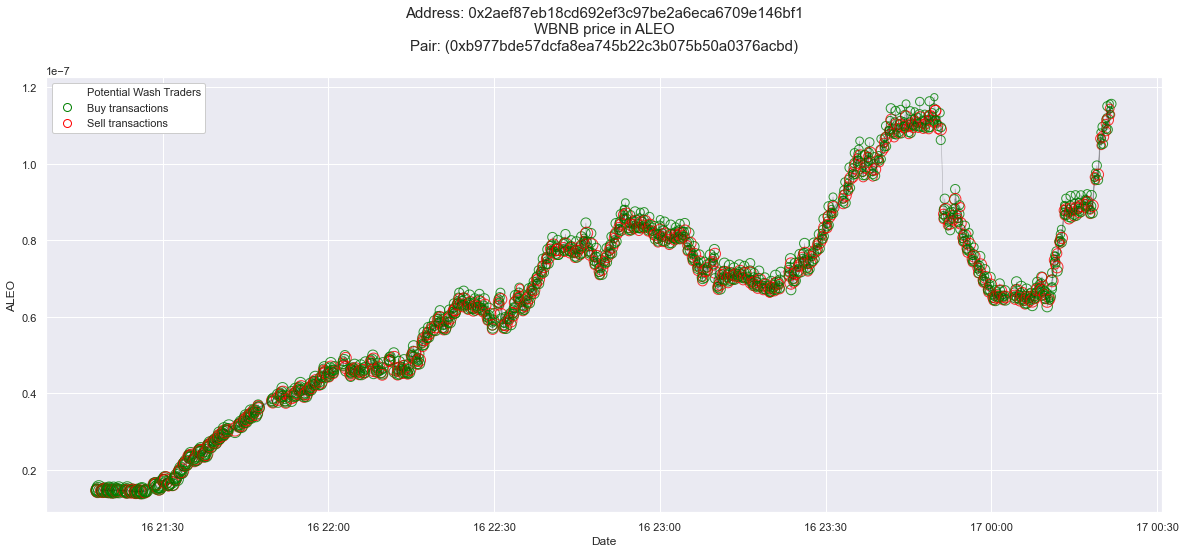

,contract_address,data,blockNumber,blockHash,timeStamp,gasPrice,gasUsed,logIndex,transactionHash,transactionIndex,event,From,To,DateTime,amount0In,amount1In,amount0Out,amount1Out,percent_txs_from_address,txs_from_address,txs_in_same_block,position_ratio,tx_size_similarity,focused_on_single_pair,most_common_pair_address,profit_in_token0,profit_in_token1,total_amount1Out_by_address,total_amount1In_by_address,total_token1_volume_by_address,total_amount0Out_by_address,total_amount0In_by_address,total_token0_volume_by_address,percent_token1_volume_by_address,percent_token0_volume_by_address,potential_wash_trading_bot,token0_price_in_token1,token1_price_in_token0,swap_size,is_0x2aef87eb18cd692ef3c97be2a6eca6709e146bf1,is_buying
12,0xb977bde57dcfa8ea745b22c3b075b50a0376acbd,0x00000000000000000000000000000000000000000000...,23115348,0x5e66af6334416f9a0b676d17f05c7d3fee344027fac5...,1668633486,5000000000,343266,110,0x22e0604a1e0fe5118aa7431cfd8a7dd45085dbe91418...,47,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x0b0f35aeeb7c1aede9f5b679c920d94f37af36e2,2022-11-16 21:18:06,0,1760100000000000000,118775902060528959361149657,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.481866e-08,6.748247e+07,86.618373,False,True
13,0xb977bde57dcfa8ea745b22c3b075b50a0376acbd,0x000000000000000000000000000000000000000000bd...,23115348,0x5e66af6334416f9a0b676d17f05c7d3fee344027fac5...,1668633486,5000000000,343266,114,0x22e0604a1e0fe5118aa7431cfd8a7dd45085dbe91418...,47,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x2aef87eb18cd692ef3c97be2a6eca6709e146bf1,2022-11-16 21:18:06,229073873469804256980402550,0,0,3358000000000000000,5.7609,583.0,6.0,6.861056e+28,0.018868,True,0xb977bde57dcfa8ea745b22c3b075b50a0376acbd,-1.681750e+28,-1.103863e+21,3399580475000000005600,0,3399580475000000005600,0,68610556777339117697277264358,68610556777339117697277264358,1.057702e-07,0.004442,False,1.465903e-08,6.821735e+07,87.565943,True,False
14,0xb977bde57dcfa8ea745b22c3b075b50a0376acbd,0x00000000000000000000000000000000000000000000...,23115348,0x5e66af6334416f9a0b676d17f05c7d3fee344027fac5...,1668633486,5000000000,343266,118,0x22e0604a1e0fe5118aa7431cfd8a7dd45085dbe91418...,47,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x6ce7ca2481a13df7af98d466a148d009bba15939,2022-11-16 21:18:06,0,1597900000000000000,109158936474470965562431354,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.463829e-08,6.831400e+07,86.496561,False,True
40,0xb977bde57dcfa8ea745b22c3b075b50a0376acbd,0x000000000000000000000000000000000000000000e0...,23115351,0xcc5b485cf5131eb5cc404b90228d3ac3f87b48213ba4...,1668633495,5000000000,280033,126,0x056855ba6b545762191ad8a221e00409d4f9fa6a2ab1...,67,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x2aef87eb18cd692ef3c97be2a6eca6709e146bf1,2022-11-16 21:18:15,271634159031762002178151343,0,0,3922774999999999700,5.7609,583.0,6.0,6.861056e+28,0.018868,True,0xb977bde57dcfa8ea745b22c3b075b50a0376acbd,-1.681750e+28,-1.103863e+21,3399580475000000005600,0,3399580475000000005600,0,68610556777339117697277264358,68610556777339117697277264358,1.057702e-07,0.004442,False,1.444139e-08,6.924541e+07,87.811795,True,False
41,0xb977bde57dcfa8ea745b22c3b075b50a0376acbd,0x00000000000000000000000000000000000000000000...,23115351,0xcc5b485cf5131eb5cc404b90228d3ac3f87b48213ba4...,1668633495,5000000000,280033,130,0x056855ba6b545762191ad8a221e00409d4f9fa6a2ab1...,67,Swap,0x10ed43c718714eb63d5aa57b78b54704e256024e,0x90a3926c2939413782fe5b0cfd07d0147a6e6282,2022-11-16 21:18:15,0,4932700000000000000,338645364413422793643189354,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,1.456598e-08,6.865314e+07,88.129906,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59797,0xb977bde57dcfa8ea745b22c3b075b50a0376acbd,0x0000000000000000000000000000000000000000001c...,23118942,0x174a299

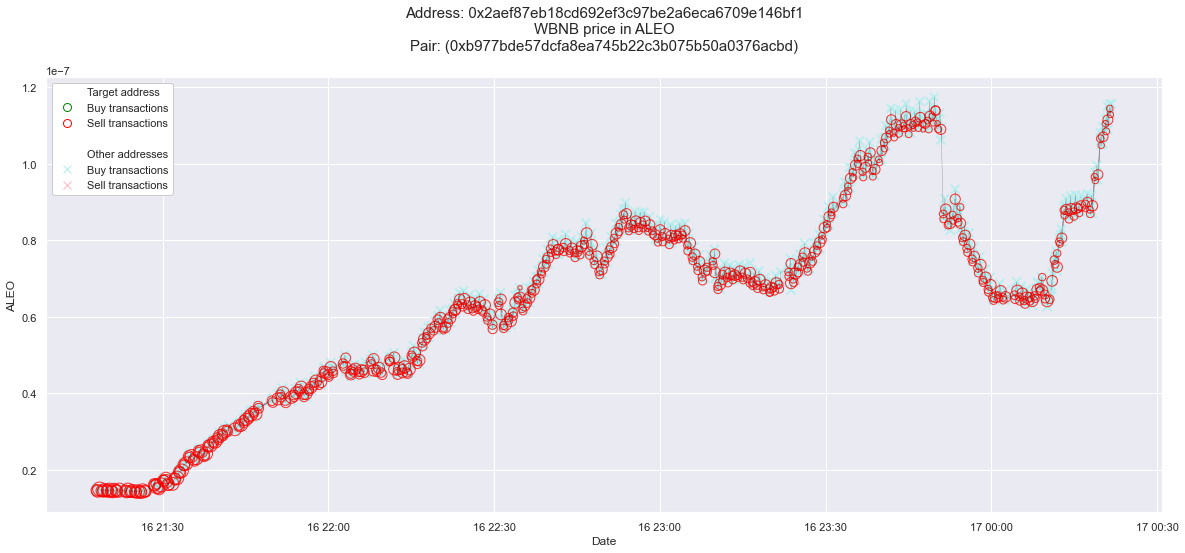

Swapper address: 0x0e0c771f29495227c9480dd187c4260e79ff9192
Pair contract address: 0x07f03fc32fde26e1ebf97bdfae495d5d7608049f


,position_ratio,potential_wash_trading_bot,address_is_contract,focused_on_single_pair,tx_size_similarity,profit_in_USDT,profit_in_USDC,profit_in_BUSD,profit_in_WBNB,volume_in_USDT,volume_in_USDC,volume_in_BUSD,volume_in_WBNB,mean_tx_size_in_USDT,mean_tx_size_in_USDC,mean_tx_size_in_BUSD,mean_tx_size_in_WBNB
1,1.05,True,False,True,0.02,NaN,NaN,NaN,-0.001722,NaN,NaN,NaN,7.310247e+17,NaN,NaN,NaN,0.004569


KeyError: 0

In [38]:
# Filter out top adresses by something: sort_values(by=[

# 1) To find most active bots, put:________________by=["percent_txs_from_address"]
# 2) To find predictable market makers, put:_______by=["tx_size_similarity"]
# 3) To find sandwitch bots, put:__________________by=["txs_in_same_block"]

x = df.drop_duplicates(subset = "To").round(2).sort_values(by = ["percent_txs_from_address"], ascending = False, kind = "mergesort").reset_index(drop = True)[:30] # only analyse top 20 addresses by percent_txs_from_address
# print(x.head())
# and check if they are contracts or simple addresses
def unique(sequence):
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

bot_list = unique([i for i in x.To.to_list() if i in set(x.To.to_list())]) # preserves order

if len(bot_list) < 200:
    iteration = 0
    for bot in bot_list:
        iteration += 1
        print(f"Analysing top {len(bot_list)} bot addresses. {iteration} out of {len(bot_list)}...", end="\r")

        # check all their txs
        _df = df[df.To == bot] 
        most_common_pair_address = max(set(_df.contract_address.to_list()), key = _df.contract_address.to_list().count) 
        _df = _df[_df.contract_address == most_common_pair_address] 
        bot_is_contract = address_is_contract(bot, w3) # takes some time
        x.loc[x.To == bot, "address_is_contract"] = bot_is_contract 

        # check hour window that the transactions occurs
        hour_window = (_df.timeStamp.max() - _df.timeStamp.min()) / (60*60)
        x.loc[x.To == bot,"hour_window"] = round(hour_window, 3)

        pair_info = get_pair_info(most_common_pair_address, abi, bsc_scan_api_key, w3) # takes some time
        pair_info["signatures"] = signatures
        
        # Calculation of profits - do it here bcs need pair_info which takes too long to run for every address in df 
        # Get token price, which is simply a ratio of the Swap
        token0_price_in_token1 = pd.to_numeric((_df.amount1In + _df.amount1Out) / (_df.amount0In + _df.amount0Out)) * (10**(pair_info["token0_decimals"] - pair_info["token1_decimals"])) # accounting for token decimals shown in contract
        # _df["token0_price_in_token1"] = token0_price_in_token1
        token1_price_in_token0 = 1 / token0_price_in_token1
        # _df["token1_price_in_token0"] = token1_price_in_token0
        
        # Get current accumulated position
        position_token0 = (_df.amount0Out.sum() - _df.amount0In.sum()) * 10** - pair_info["token0_decimals"]
        position_token1 = (_df.amount1Out.sum() - _df.amount1In.sum()) * 10** - pair_info["token1_decimals"]
        # Get profits in terms of token0 and token1 
        address_position_token0 = position_token0 + (position_token1 * token1_price_in_token0.iloc[-1]) # token1_price_in_token0 is series - take only last item!
        address_position_token1 = position_token1 + (position_token0 * token0_price_in_token1.iloc[-1])

        #Get volume of the token0 and token1
        token0_volume = (_df.amount0Out.sum() + _df.amount0In.sum())
        token1_volume = (_df.amount1Out.sum() + _df.amount1In.sum())
        


        for i in ["USDT", "USDC", "BUSD", "WBNB"]:
            x.loc[x.To == bot, f"profit_in_{i}"] = np.nan # default value
            x.loc[x.To == bot, f"mean_tx_size_in_{i}"] = np.nan # default value
            x.loc[x.To == bot, f"volume_in_{i}"] = np.nan # default value

        # When need to know what is the reference coin:
        if pair_info['token0_symbol'] in ["USDT", "USDC", "BUSD", "WBNB"]:
            # show profit in reference token
            x.loc[x.To == bot, f"profit_in_{pair_info['token0_symbol']}"] = address_position_token0

            # check mean swap size in reference token:
            x.loc[x.To == bot, f"mean_tx_size_in_{pair_info['token0_symbol']}"] = (_df.amount0Out.sum() + _df.amount0In.sum())* 10**-pair_info["token0_decimals"] / len(_df)

            # show volume in reference token
            x.loc[x.To == bot, f"volume_in_{pair_info['token0_symbol']}"] = token0_volume

        elif pair_info['token1_symbol'] in ["USDT", "USDC", "BUSD", "WBNB"]:
            # show profit in reference token
            x.loc[x.To == bot, f"profit_in_{pair_info['token1_symbol']}"] = address_position_token1

            # check mean swap size in reference token:
            x.loc[x.To == bot, f"mean_tx_size_in_{pair_info['token1_symbol']}"] = (_df.amount1Out.sum() + _df.amount1In.sum())* 10**-pair_info["token1_decimals"] / len(_df)

            # show volume in reference token
            x.loc[x.To == bot, f"volume_in_{pair_info['token1_symbol']}"] = token1_volume
        
        else:
            print()
            print(f"There is no reference coin in pair {most_common_pair_address}? {pair_info['token0_symbol']} vs {pair_info['token1_symbol']}")
        
        if bot_is_contract:
            print(f"Swapper contract: {bot}")

        else:
            print(f"Swapper address: {bot}")

        print(f"Pair contract address: {most_common_pair_address}")

        display(x.loc[x.To == bot][[
            "position_ratio",
            "potential_wash_trading_bot",
            "address_is_contract",
            "focused_on_single_pair",
            "tx_size_similarity",
            # "USDT",
            # "BUSD",
            # "WBNB",
            "profit_in_USDT",
            "profit_in_USDC",
            "profit_in_BUSD",
            "profit_in_WBNB",
            "volume_in_USDT",
            "volume_in_USDC",
            "volume_in_BUSD",
            "volume_in_WBNB",
            "mean_tx_size_in_USDT",
            "mean_tx_size_in_USDC",
            "mean_tx_size_in_BUSD",
            "mean_tx_size_in_WBNB"]])

        # wash_trading = x.loc[x.To == bot, "potential_wash_trading_bot"]
        # print(wash_trading)
        # if not wash_trading.iat[0]:
        #     continue
        if x.loc[x.To == bot, "position_ratio"].at[0] > 100000:
            find_other_txs_and_analyze_them(df, bot, pair_info)
        # display(df.head(10))
        plot_address_txs(df, bot, pair_info)
        # break
        # print()

# # Identify potential sandwitch bots based on having any txs_in_same_block and having very balanced position (always buys and sells immediately)
# x["potential_sandwitch_bot"] = False
# x.loc[(x.txs_in_same_block>0) 
# & (x.position_ratio < 1.1)
# , "potential_sandwitch_bot"] = True

# should calculate profits differently if position is balanced.

contract_list = set(x[x.address_is_contract == True].To.to_list())
print()
print(" " * 100, end = "\r")
print(f"Identified {len(bot_list)} adresses as bots, {len(contract_list)} of which are contracts")

x[
["To",
"hour_window",
"txs_from_address",
"percent_txs_from_address",
"txs_in_same_block",
"position_ratio",
"potential_wash_trading_bot",
"address_is_contract",
"focused_on_single_pair",
"most_common_pair_address",
"tx_size_similarity",
# "USDT",
# "BUSD",
# "WBNB",
"profit_in_USDT",
"profit_in_USDC",
"profit_in_BUSD",
"profit_in_WBNB",
"mean_tx_size_in_USDT",
"mean_tx_size_in_USDC",
"mean_tx_size_in_BUSD",
"mean_tx_size_in_WBNB",
"volume_in_USDT",
"volume_in_USDC",
"volume_in_BUSD",
"volume_in_WBNB",
"total_token1_volume_by_address",
"total_token0_volume_by_address",
"percent_token1_volume_by_address",
"percent_token0_volume_by_address",
# "to_address_is_contract",
# "to_address_is_bot",
# "Txhash"
# "profit_in_token0",
# "profit_in_token1"
]].rename(columns = {"To": "swapper"})

## Check address or pair on websites

In [ ]:
# DEX TOOLS

pair_address = "0xe79792f57feb774c98b9c0ae3879e94151bbc6fd"
# open pair in dextools
browser=webbrowser.open(f"https://www.dextools.io/app/bnb/pair-explorer/{pair_address}")

In [ ]:
# BSC SCAN

# for address in x.To.to_list():
address = "0x8b8278b399755c8a1118a61e09efaac75ecd7f9e"
browser=webbrowser.open(f"https://bscscan.com/address/{address}#tokentxns")